## 因果挑战比赛：预测行动/干预的结果

因果挑战比赛旨在对行动/干预的结果进行预测。

#### 比赛网站
* http://www.causality.inf.ethz.ch/challenge.php

#### 主要结果

* LUCAS

|  模型  |          特征变量        |  LUCAS0 | LUCAS1|LUCAS2|
| :----:| :-----------------------:|:-------:|:-----:|:----:|
|XGBoost|        所有特征变量       |  0.9204 |       |      |
|XGBoost|         马尔科夫毯        |  0.9214 |       |      |
|XGBoost|Smoking，Genetics，Allergy，Cough|   |0.9098 |      |
|XGBoost|Smoking，Genetics        |          |       |0.7958|
|逻辑回归|        所有特征变量       |  0.9196 |       |      |
|逻辑回归|Smoking，Genetics，Allergy，Cough|  |0.9097 |       |
|逻辑回归|Smoking，Genetics        |          |       |0.7958|

* LUCAP

|  模型  |          特征变量        |  LUCAP0 | LUCAP1|LUCAP2|
| :----:| :-----------------------:|:----:|:---:|:---:|
|XGBoost|        所有特征变量       |0.9742|||
|XGBoost|        26,143,85,59,2       ||0.8025||
|XGBoost|     26,143,85,59,2,78,69    ||0.8118||
|XGBoost|     26,143,85,59,2,78,69,117||0.8138||
|XGBoost|        26,143,85,59,2       |||0.4970|
|XGBoost|     26,143,85,59,2,78,69    |||0.6814|
|XGBoost|     26,143,85,59,2,78,69,117|||0.4970|
|逻辑回归|        所有特征变量       |0.9705|||
|逻辑回归|        26,143,85,59,2       ||0.7840||
|逻辑回归|     26,143,85,59,2,78,69    ||0.8054||
|逻辑回归|     26,143,85,59,2,78,69,117||0.8074||
|逻辑回归|        26,143,85,59,2       |||0.4889|
|逻辑回归|     26,143,85,59,2,78,69    |||0.4971|
|逻辑回归|     26,143,85,59,2,78,69,117|||0.4974|

* REGED

|  模型  |          特征变量        |  REGED0 | REGED1|REGED2|
| :----:| :-----------------------:|:----:|:---:|:---:|
|XGBoost|        所有特征变量       |0.9994|||
|XGBoost|251,321,453,344,930,825,312||0.9809||
|XGBoost|251,321,453,344,930,825||0.9844||
|XGBoost|251,321,930,825,312       |||0.8546|
|XGBoost|251,321,930,825       |||0.8378|
|逻辑回归|        所有特征变量       |0.9971|||
|逻辑回归|251,321,453,344,930,825,312||0.9644||
|逻辑回归|251,321,453,344,930,825||0.9639||
|逻辑回归|251,321,930,825,312       |||0.9243|
|逻辑回归|251,321,930,825       |||0.9240|

#### 详细内容

In [19]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

sns.set_style('white')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']}) #图中显示中文

In [20]:
# 使用交叉验证确定超参数
def cv_result(clf, parameter_dic, Xtrain, ytrain, cross_validation_fold=5, scoring='roc_auc'):
    """
    Cross validation result for sklearn type model.
    """
    
    param_tune = list(parameter_dic.keys())[0]
    train_scores, val_scores=validation_curve(estimator=clf,
                                               X=Xtrain,
                                               y=ytrain,
                                               param_name=param_tune,
                                               param_range=parameter_dic[param_tune],
                                               cv=cross_validation_fold, scoring=scoring)
    train_mean=np.mean(train_scores, axis=1)
    val_mean=np.mean(val_scores, axis=1)
    
    return train_mean, val_mean

def cv_result_xgboost(param, parameter_dic, Xtrain, ytrain, cross_validation_fold=5):
    """
    Cross validation result for xgboost.
    """
    
    param_tune = list(parameter_dic.keys())[0]
    param_len = len(parameter_dic[param_tune])

    xgb_cv = []
    kf = KFold(n_splits=cross_validation_fold, shuffle=True, random_state=42)

    train_mean = []
    val_mean = []

    clf_progress = {}
    clf_num_boost_round_mean = []

    for i in range(param_len):
        param[param_tune] = parameter_dic[param_tune][i]

        train_scores = []
        val_scores = []

        clf_num_boost_round = []

        for train, val in kf.split(Xtrain, ytrain):
            dtrain = xgb.DMatrix(Xtrain[train], label = ((ytrain+1)/2)[train])
            dval = xgb.DMatrix(Xtrain[val], label = ((ytrain+1)/2)[val])
            clf = xgb.train(params=param, dtrain=dtrain,
                            num_boost_round=3000,
                            early_stopping_rounds=25, evals=[(dval,'validation')],
                            evals_result=clf_progress,
                            verbose_eval=False)
            clf_num_boost_round.append(len(clf_progress['validation']['auc']))
            train_scores.append(roc_auc_score(ytrain[train], clf.predict(dtrain)))
            val_scores.append(roc_auc_score(ytrain[val], clf.predict(dval)))

        train_mean.append(np.mean(np.array(train_scores)))
        val_mean.append(np.mean(np.array(val_scores)))

        clf_num_boost_round_mean.append(np.mean(np.array(clf_num_boost_round)))

    return train_mean, val_mean, clf_num_boost_round_mean

def plot_cv_curve(clf, train_mean, val_mean, parameter_dic):
    """
    Plot cross validation curve.
    """

    param_tune = list(parameter_dic.keys())[0]
    clf_dict = {'LogisticRegression': '逻辑回归',
                'GradientBoostingClassifier': '梯度提升',
                'RandomForestClassifier': '随机森林'
               }

    plt.figure(figsize=(12, 8))
    plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
    plt.plot(parameter_dic[param_tune], train_mean,
             color='blue',marker='o',
             markersize=5,label='训练数据')
    plt.plot(parameter_dic[param_tune], val_mean,
             color='green',linestyle='--',
             marker='s',markersize=5,label='交叉验证数据')
    plt.xlabel('超参数：{}'.format(param_tune))
    plt.ylabel('ROC')
    plt.legend()
    try:
        plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
        if clf.__class__.__name__ == 'LogisticRegression':
            plt.xscale('log')
    except Exception as e:
        plt.title('{}'.format(clf.__name__))
    print('最优的{}为：{}'.format(param_tune, parameter_dic[param_tune][np.argmax(val_mean)]))
    print('AUC（交叉验证数据）：{:.4f}'.format(np.max(val_mean)))

In [21]:
def prediction(best_clf, Xtrain, ytrain, Xtest):
    """
    Prediction of sklearn stype model.
    """
    
    best_clf.fit(Xtrain, ytrain)
    ytrain_pred_proba = best_clf.predict_proba(Xtrain)[:,1]
    ytest_pred_proba = best_clf.predict_proba(Xtest)[:,1]

    return ytrain_pred_proba, ytest_pred_proba

def prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest):
    """
    Prediction of xgboost.
    """
    
    dtrain = xgb.DMatrix(Xtrain, label = (ytrain+1)/2)
    best_clf = xgb.train(params=param, dtrain=dtrain,
                         num_boost_round=int(num_boost_round),
                         verbose_eval=False)
    ytrain_pred_proba = best_clf.predict(dtrain)
    dtest = xgb.DMatrix(Xtest)
    ytest_pred_proba = best_clf.predict(dtest)
    
    return ytrain_pred_proba, ytest_pred_proba

def output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel):
    with open('{}_train.predict'.format(test_dataset), 'w') as f:
        f.write(' \n'.join([str(i) for i in ytrain_pred_proba]))
    with open('{}_test.predict'.format(test_dataset), 'w') as f:
        f.write(' \n'.join([str(i) for i in ytest_pred_proba]))
    with open('{}_feat.ulist'.format(test_dataset), 'w') as f:
        f.write(' '.join([str(feature_cols.index(i)+1) for i in feature_sel]))

#### 1. LUCAS (LUng CAncer Simple set)

数据说明
* 整个数据集分为3部分：LUCAS0、LUCAS1和LUCAS2，其中3个部分的训练数据都相同，为包含特征变量和目标变量的观察数据
* LUCAS0：没有干预，测试数据与训练数据同分布，均为观察数据
* LUCAS1：训练数据为干预条件下的数据，干预变量为：Yellow Fingers, Smoking, Fatigue, Attention Disorder
* LUCAS2：训练数据为干预条件下的数据，干预变量为：除目标变量（Lung Cancer）以外的所有变量

预测方法
* LUCAS0问题是对观察条件下的结果进行预测，其测试数据与训练数据同分布，因此预测仅需要利用变量间的相关关系。解决此问题的方法为使用监督学习算法在训练数据上估计$P(Y|X)$，其中$Y$为目标变量，$X$为所有的特征变量。
* LUCAS1和LUCAS2问题是对干预条件下的结果进行预测，因此需要根据因果图使用干预运算规则把干预条件转化为非干预条件，从而使得利用观察数据来预测干预条件下的结果称为可能。干预运算规则及因果模型相关理论参见Pearl (2009)[$^{[1]}$](http://bayes.cs.ucla.edu/BOOK-2K/)。

1.1 导入训练数据

In [33]:
dataset = 'lucas'

feature_cols = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder',
                'Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing']
target_col = ['Lung_Cancer']

Xtrain_df = pd.read_table(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0_train.data'.format(dataset)), names=feature_cols, sep=' ', index_col=False)
ytrain_df = pd.read_table(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0_train.targets'.format(dataset)), names=target_col, sep=' ', index_col=False)

df = pd.concat([Xtrain_df, ytrain_df], axis=1)
df.to_csv(os.path.join('{}.csv'.format(dataset)), index=False)

1.2 根据因果关系图，将干预条件转化为非干预条件。

<img src="images/lucas_graph0.gif" />

LUCAS1

\begin{align}
P(LC|\hat {YF}, \hat S, \hat {AD}, \hat F, O)
&=P(LC|\hat {YF}, \hat S, \hat {AD}, \hat F, G, A, C)\\
&=P(LC|\hat {YF}, \hat S, \hat F, G, A, C)\\
&=P(LC|\hat S, \hat F, G, A, C)\\
&=P(LC|S, \hat F, G, A, C)\\
&=P(LC|S, G, A, C)\\
\end{align}

LUCAS2

\begin{align}
P(LC|\hat {ALL})
&=P(LC|\hat S, \hat G)\\
&=P(LC|S, G)\\
\end{align}

1.3 根据干预计算结果，选择对应的特征变量：
* LUCAS0为所有特征变量，利用训练数据估计$P(LC|X)$
* LUCAS1为Smoking，Genetics，Allergy，Cough，利用训练数据估计$P(LC|S, G, A, C)$
* LUCAS2为Smoking，Genetics，利用训练数据估计$P(LC|S, G)$

1.4 分别使用逻辑回归和XGBoost算法进行监督学习，选择交叉验证集上ROC曲线下面积（AUC，Area Under ROC Curve）更高的一种模型对训练数据进行预测。

1.4.1 LUCAS0

In [34]:
dataset_number = 0
feature_sel = feature_cols

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：100
AUC（交叉验证数据）：0.9161


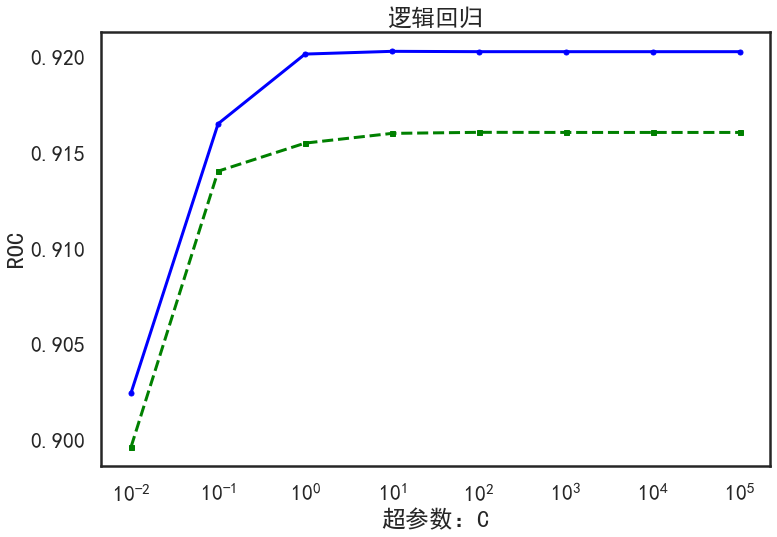

In [24]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.4299999999999998
AUC（交叉验证数据）：0.9193


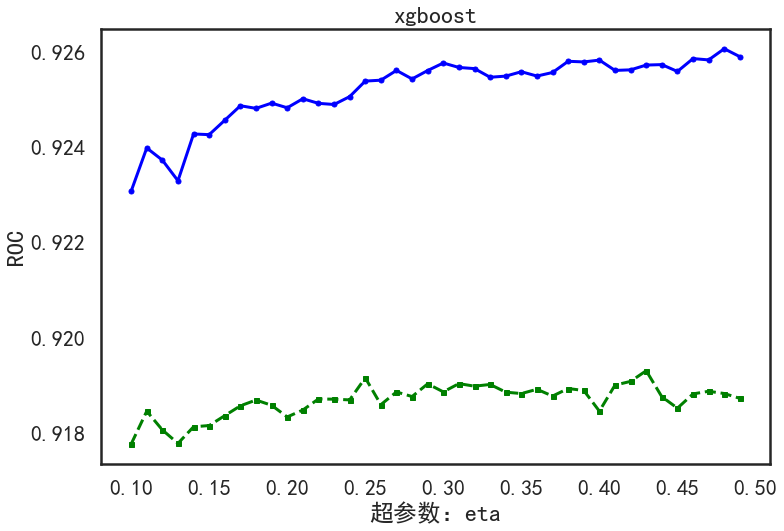

In [35]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.43
param['subsample'] = 1.0
param['colsample_bytree'] = 0.4
param['max_depth'] = 2
param['num_parallel_tree'] = 4
param['min_child_weight'] = 1

parameter_dic = {'eta':np.arange(0.1, 0.5, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用XGBoost及其最优超参数对测试数据进行预测，输出提交文件。

In [36]:
# XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.43
param['subsample'] = 1.0
param['colsample_bytree'] = 0.4
param['max_depth'] = 2
param['num_parallel_tree'] = 4
param['min_child_weight'] = 1

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [25]:
#best_clf = LogisticRegression(C=100, multi_class='auto', solver='liblinear')
#ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
#output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

1.4.2 LUCAS1

In [37]:
dataset_number = 1
feature_sel = ['Smoking', 'Genetics', 'Allergy', 'Coughing']

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：1000
AUC（交叉验证数据）：0.9091


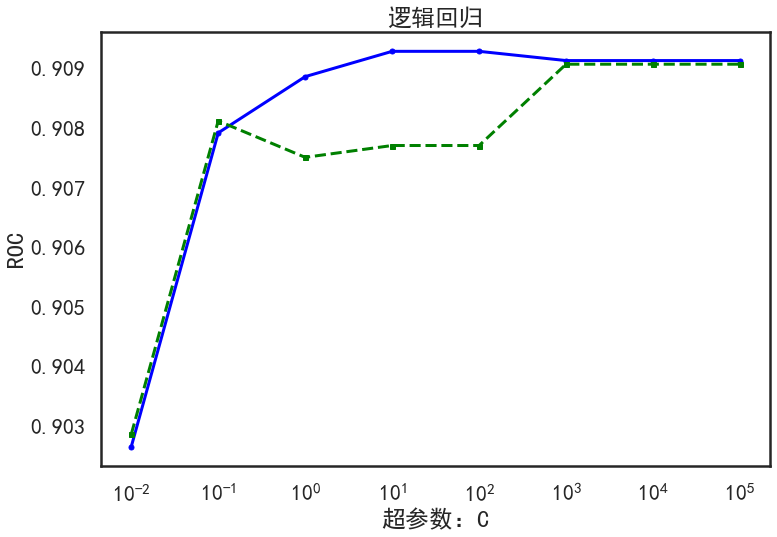

In [27]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.27
AUC（交叉验证数据）：0.9102


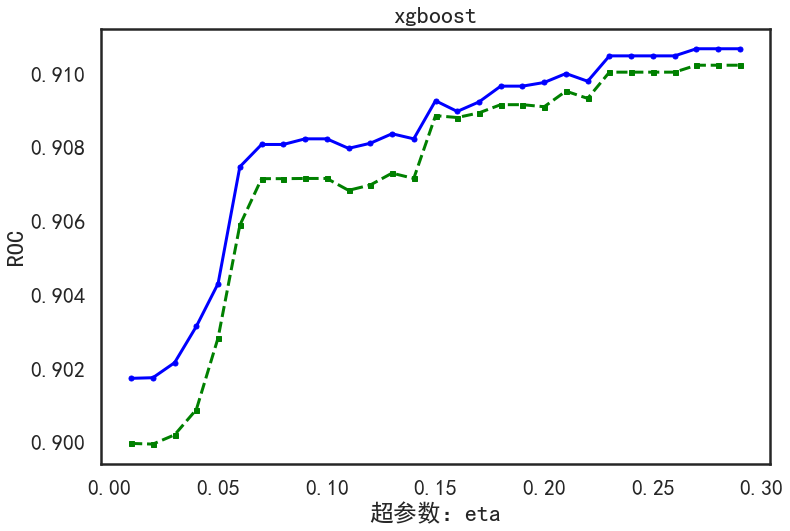

In [11]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.27
param['subsample'] = 1.0
param['colsample_bytree'] = 0.5
param['max_depth'] = 2
param['num_parallel_tree'] = 4
param['min_child_weight'] = 0

parameter_dic = {'eta':np.arange(0.01, 0.3, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用XGBoost及其最优超参数对测试数据进行预测，输出提交文件。

In [38]:
# XGBoost
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.27
param['subsample'] = 1.0
param['colsample_bytree'] = 0.5
param['max_depth'] = 2
param['num_parallel_tree'] = 4
param['min_child_weight'] = 0

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [28]:
#best_clf = LogisticRegression(C=1000, multi_class='auto', solver='liblinear')
#ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
#output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

1.4.2 LUCAS2

In [39]:
dataset_number = 2
feature_sel = ['Smoking', 'Genetics']

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：1
AUC（交叉验证数据）：0.7858


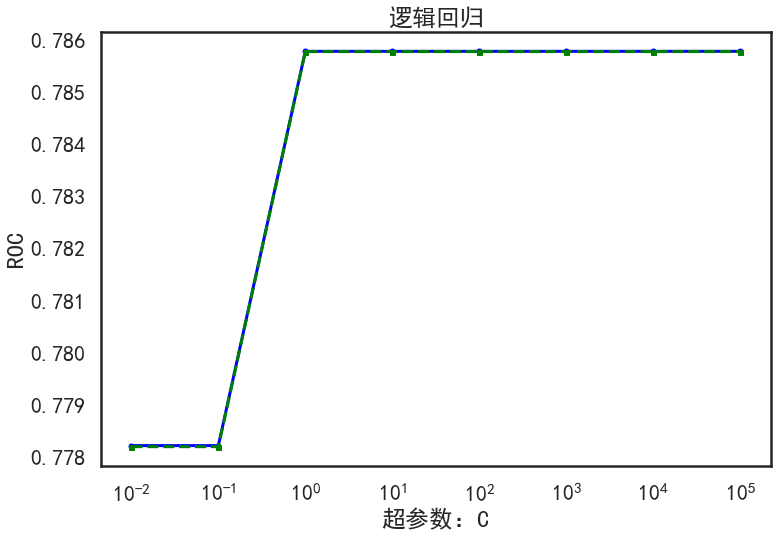

In [30]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.14
AUC（交叉验证数据）：0.7855


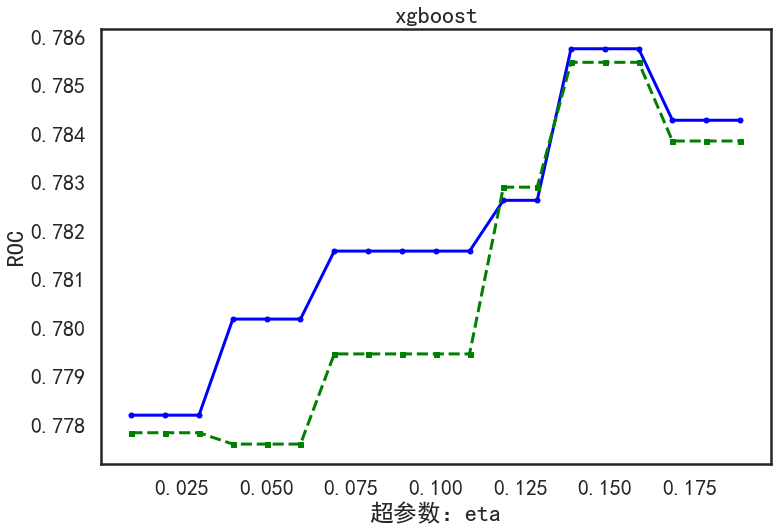

In [40]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.14
param['subsample'] = 0.1
param['colsample_bytree'] = 0.1
param['max_depth'] = 1
param['num_parallel_tree'] = 1
param['min_child_weight'] = 1

parameter_dic = {'eta':np.arange(0.01, 0.2, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用逻辑回归及其最优超参数对测试数据进行预测，输出提交文件。

In [41]:
# XGBoost
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.14
param['subsample'] = 0.1
param['colsample_bytree'] = 0.1
param['max_depth'] = 1
param['num_parallel_tree'] = 1
param['min_child_weight'] = 1

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [31]:
best_clf = LogisticRegression(C=1,multi_class='auto', solver='liblinear')
ytrain_pred_proba, ytest_pred_proba = prediction(best_clf, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

1.5 对三个数据集均完成预测后，输出提交文件。

In [42]:
with ZipFile('{}.zip'.format(dataset), 'w') as zipObj:
    for i in range(3):
        zipObj.write('{}{}_train.predict'.format(dataset, i))
        zipObj.write('{}{}_test.predict'.format(dataset, i))
        zipObj.write('{}{}_feat.ulist'.format(dataset, i))

#### 2. LUCAP (LUng CAncer set with Probes)

数据说明
* 整个数据集分为3部分：LUCAP0、LUCAP1和LUCAP2，其中3个部分的训练数据都相同，为包含特征变量和目标变量的观察数据
* LUCAP0：没有干预，测试数据与训练数据同分布，均为观察数据
* LUCAP1：训练数据为干预条件下的数据，干预变量为所有的探针变量
* LUCAP2：训练数据为干预条件下的数据，干预变量为所有的探针变量

预测方法
* LUCAP0问题是对观察条件下的结果进行预测，其测试数据与训练数据同分布，因此预测仅需要利用变量间的相关关系。解决此问题的方法为使用监督学习算法在训练数据上估计$P(Y|X)$，其中$Y$为目标变量，$X$为所有的特征变量。
* LUCAP1和LUCAP2问题是对干预条件下的结果进行预测，因此需要根据因果图使用干预运算规则把干预条件转化为非干预条件。由题意知，所有的探针变量都不能是目标变量的原因变量，因此在干预探针变量条件下进行预测最理想的情况是找到目标变量的马尔科夫毯，其次为找到目标变量的所有直接原因变量（目标变的直接结果变量和探针变量无法区分）。

2.1 导入训练数据

In [43]:
dataset = 'lucap'

with open(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0.param'.format(dataset))) as f:
    text = f.read()
feature_cols = [str(i) for i in range(1, int(text[text.find('features')+10:text.find('\nNumber of examples')])+1)]
target_col = ['target']

Xtrain_df = pd.read_table(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0_train.data'.format(dataset)), names=feature_cols, sep=' ', index_col=False)
ytrain_df = pd.read_table(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0_train.targets'.format(dataset)), names=target_col, sep=' ', index_col=False)

df = pd.concat([Xtrain_df, ytrain_df], axis=1)
df.to_csv('{}.csv'.format(dataset), index=False)

2.2 发现变量间的因果关系

将包含特征变量和目标变量的训练数据lucap.csv导入[Tetrad](http://www.phil.cmu.edu/tetrad/)（本文使用版本为6.7.0），选择PC Variants算法，使用默认参数设置进行搜索，得到变量间的因果关系图。与目标变量相关的因果关系图部分如下所示。

<img src="images/lucap_graph.png" />

2.3 根据因果关系图，将干预条件转化为非干预条件。

LUCAP1&2

$$P(target|\hat P, X)=P(target|26, 143, 85, 59, 2)$$

2.4 根据干预计算结果，选择对应的特征变量集：
* LUCAP0为所有特征变量，利用训练数据估计$P(target|X)$
* LUCAP1&2为26，143，85，59，2，利用训练数据估计$P(target|26, 143, 85, 59, 2)$

2.5 分别使用逻辑回归和XGBoost算法进行监督学习，选择交叉验证集上AUC更高的一种模型对训练数据进行预测。

2.5.1. LUCAP0

In [44]:
dataset_number = 0
feature_sel = feature_cols

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：0.1
AUC（交叉验证数据）：0.9705


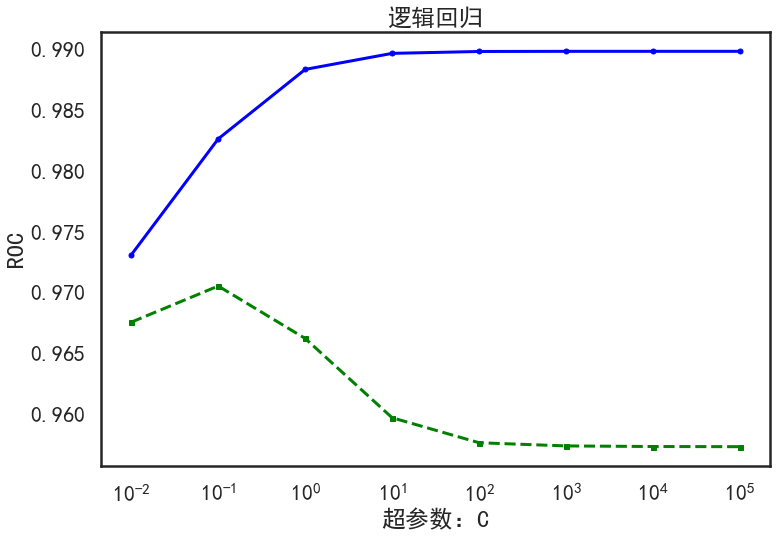

In [45]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.13
AUC（交叉验证数据）：0.9745


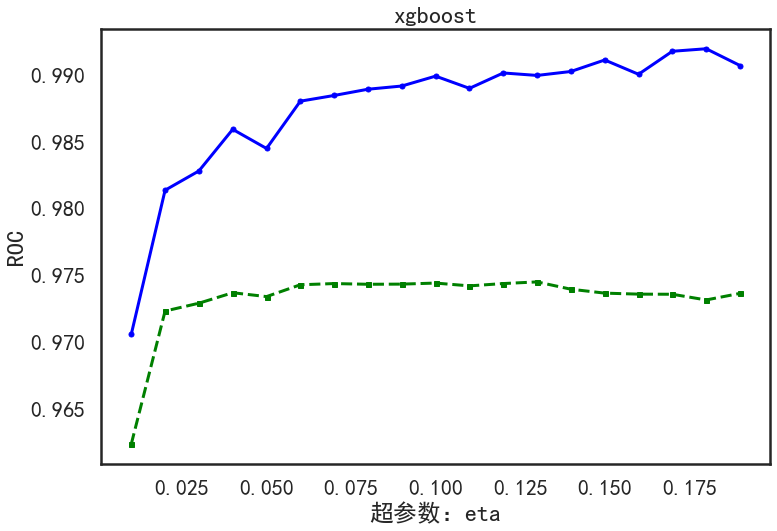

In [70]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.13
param['subsample'] = 1.0
param['colsample_bytree'] = 0.6
param['max_depth'] = 2
param['num_parallel_tree'] = 4
param['min_child_weight'] = 2

parameter_dic = {'eta':np.arange(0.01, 0.2, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用XGBoost及其最优超参数对测试数据进行预测，输出提交文件。

In [71]:
# XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.13
param['subsample'] = 1.0
param['colsample_bytree'] = 0.6
param['max_depth'] = 2
param['num_parallel_tree'] = 4
param['min_child_weight'] = 2

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [46]:
best_clf = LogisticRegression(C=0.1,multi_class='auto', solver='liblinear')
ytrain_pred_proba, ytest_pred_proba = prediction(best_clf, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

2.5.2 LUCAP1

In [57]:
dataset_number = 1
feature_sel = [str(i) for i in [26,143,85,59,2,78,69,117]]

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：10
AUC（交叉验证数据）：0.9622


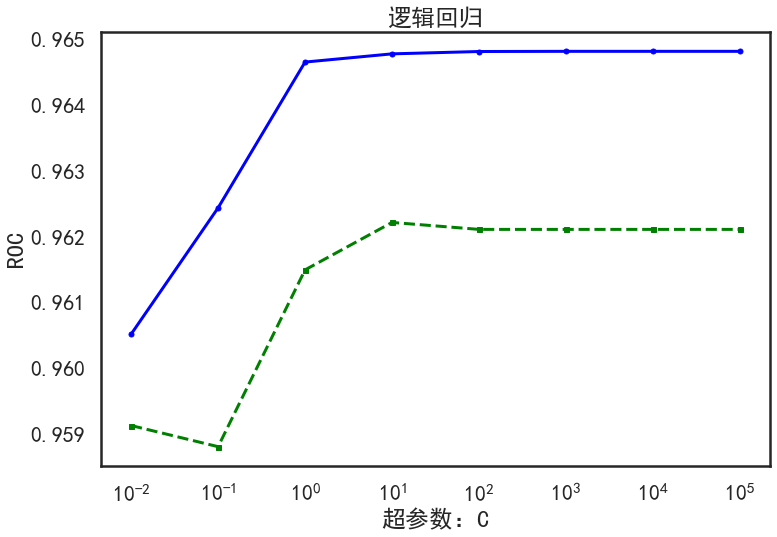

In [58]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.37
AUC（交叉验证数据）：0.9693


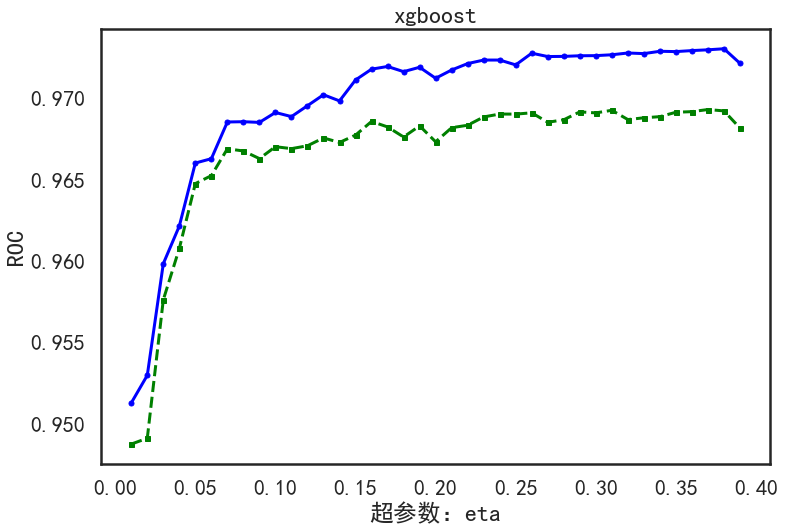

In [15]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.37
param['subsample'] = 0.5
param['colsample_bytree'] = 0.6
param['max_depth'] = 2
param['num_parallel_tree'] = 6
param['min_child_weight'] = 2

parameter_dic = {'eta':np.arange(0.01, 0.4, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用XGBoost及其最优超参数对测试数据进行预测，输出提交文件。

In [16]:
# XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.37
param['subsample'] = 0.5
param['colsample_bytree'] = 0.6
param['max_depth'] = 2
param['num_parallel_tree'] = 6
param['min_child_weight'] = 2

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [59]:
best_clf = LogisticRegression(C=10,multi_class='auto', solver='liblinear')
ytrain_pred_proba, ytest_pred_proba = prediction(best_clf, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

2.5.3 LUCAP2

In [60]:
dataset_number = 2
test_dataset = '{}{}'.format(dataset, dataset_number)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

2.6 对三个数据集均完成预测后，输出提交文件。

In [61]:
with ZipFile('{}.zip'.format(dataset), 'w') as zipObj:
    for i in range(3):
        zipObj.write('{}{}_train.predict'.format(dataset, i))
        zipObj.write('{}{}_test.predict'.format(dataset, i))
        zipObj.write('{}{}_feat.ulist'.format(dataset, i))

#### 3. REGED (REsimulated Gene Expression Dataset)

数据说明
* 整个数据集分为3部分：REGED0、REGED1和REGED2，其中3个部分的训练数据都相同，为包含特征变量和目标变量的观察数据
* REGED0：没有干预，测试数据与训练数据同分布，均为观察数据
* REGED1：训练数据为干预条件下的数据，干预变量为：20, 27, 36, 70, 82, 83, 85, 91, 118, 125, 139, 143, 160, 169, 176, 185, 191, 204, 219, 224, 229, 239, 243, 251, 252, 269, 281, 282, 295, 297, 301, 319, 320, 321, 342, 350, 357, 359, 361, 378, 387, 407, 409, 412, 429, 430, 469, 472, 499, 501, 507, 512, 540, 545, 552, 561, 566, 572, 580, 586, 593, 618, 622, 637, 651, 663, 674, 681, 683, 686, 690, 702, 727, 754, 762, 764, 773, 786, 805, 815, 835, 861, 872, 873, 877, 880, 889, 904, 935, 936, 939, 942, 949, 962, 977, 985, 989, 991, 992, 994
* REGED2：训练数据为干预条件下的数据，干预变量为：目标变量的所有直接结果变量以及其他变量

预测方法
* REGED0问题是对观察条件下的结果进行预测，其测试数据与训练数据同分布，因此预测仅需要利用变量间的相关关系。解决此问题的方法为使用监督学习算法在训练数据上估计$P(Y|X)$，其中$Y$为目标变量，$X$为所有的特征变量。
* REGED1和REGED2问题是对干预条件下的结果进行预测，因此首先需要得到变量间的因果关系，然后再根据因果关系图使用干预运算规则把干预条件转化为非干预条件。本数据集使用PC算法[$^{[2]}$](http://www.cs.cmu.edu/afs/cs.cmu.edu/project/learn-43/lib/photoz/.g/web/.g/scottd/fullbook.pdf)来发现变量间的因果关系。

3.1 导入训练数据

In [62]:
dataset = 'reged'

with open(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0.param'.format(dataset))) as f:
    text = f.read()
feature_cols = [str(i) for i in range(1, int(text[text.find('features')+10:text.find('\nNumber of examples')])+1)]
target_col = ['target']

Xtrain_df = pd.read_table(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0_train.data'.format(dataset)), names=feature_cols, sep=' ', index_col=False)
ytrain_df = pd.read_table(os.path.join(dataset.upper(), '{}0_text'.format(dataset), '{}0_train.targets'.format(dataset)), names=target_col, sep=' ', index_col=False)

df = pd.concat([Xtrain_df, ytrain_df], axis=1)
df.to_csv('{}.csv'.format(dataset), index=False)

3.2 发现变量间的因果关系

将包含特征变量和目标变量的训练数据reged.csv导入[Tetrad](http://www.phil.cmu.edu/tetrad/)（本文使用版本为6.7.0），选择PC Variants算法，使用默认参数设置进行搜索，得到变量间的因果关系图。与目标变量相关的因果关系图部分如下所示。

<img src="images/reged_graph.png" />

3.3 根据因果关系图，将干预条件转化为非干预条件。

REGED1

\begin{align}
P(target|\hat Z, X-Z)
&=P(target|\hat Z, MB_o)\\
&=P(target|\hat {MB}_h, {MB}_o)\\
&=P(target|\hat {939}, \hat {83}, \hat {593}, \hat {251}, \hat {321}, \hat {409}, 453, 344, 930, 825, 312)\\
&=P(target|\hat {251}, \hat {321}, 453, 344, 930, 825, 312)\\
&=P(target|251, 321, 453, 344, 930, 825, 312)\\
\end{align}

其中$MB$为目标变量的马尔科夫毯（Markov blanket），包含目标变量所有的父节点、子节点以及配偶节点。${MB}_h$为马尔科夫毯中被干预的变量集，${MB}_o$为马尔科夫毯中没有被干预的变量集。

REGED2

\begin{align}
P(target|\hat {MB}_c, \hat Z, X-Z-{MB}_c)
&=P(target|\hat {MB}_c, MB-{MB}_c)\\
&=P(target|251, 321, 930, 825)\\
\end{align}

其中$MB_c$为目标变量的子节点，Z为其他干预变量。

3.4 根据干预计算结果，选择对应的特征变量集：
* REGED0为所有特征变量，利用训练数据估计$P(target|X)$
* REGED1为251, 321, 453, 344, 930, 825，312利用训练数据估计$P(target|251, 321, 453, 344, 930, 825, 312)$
* REGED2为251, 321, 930, 825，利用训练数据估计$P(target|251, 321, 930, 825)$

3.5 分别使用逻辑回归和XGBoost算法进行监督学习，选择交叉验证集上ROC曲线下面积（AUC，Area Under ROC Curve）更高的一种模型对训练数据进行预测。

3.5.1. REGED0

In [69]:
dataset_number = 0
feature_sel = feature_cols

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：0.1
AUC（交叉验证数据）：0.9964


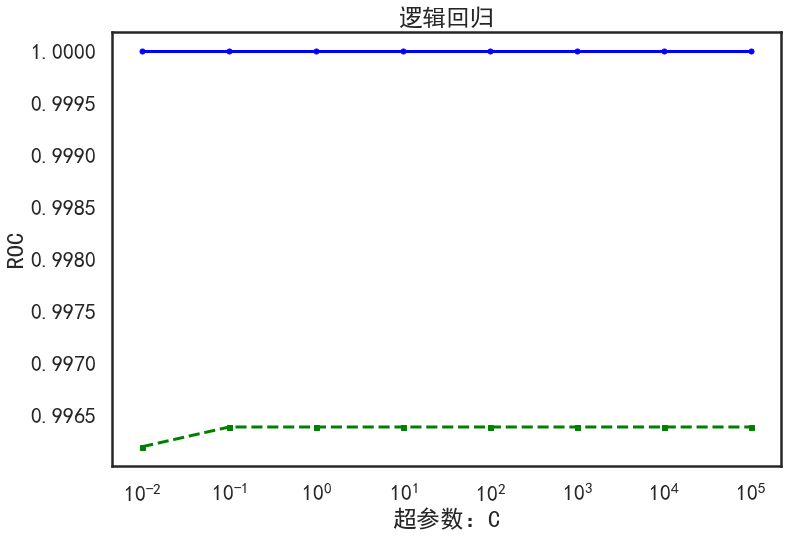

In [70]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.19
AUC（交叉验证数据）：0.9998


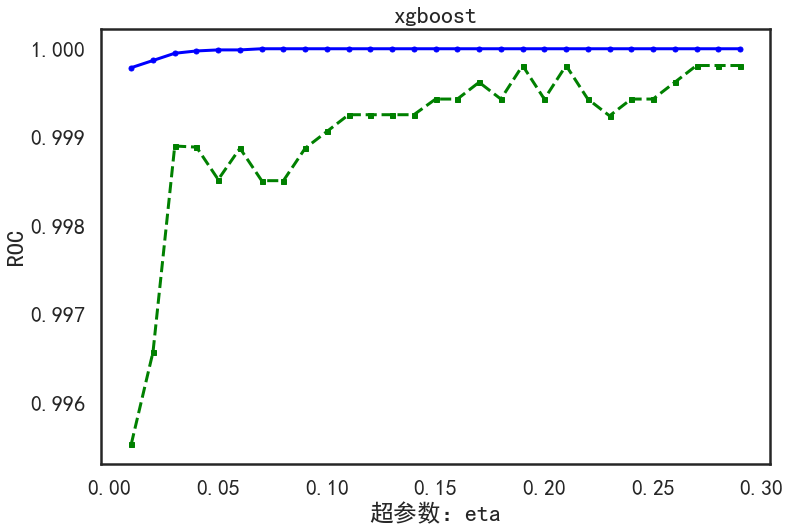

In [21]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.19
param['subsample'] = 1.0
param['colsample_bytree'] = 0.1
param['max_depth'] = 3
param['num_parallel_tree'] = 7
param['min_child_weight'] = 5

parameter_dic = {'eta':np.arange(0.01, 0.3, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用XGBoost及其最优超参数对测试数据进行预测，输出提交文件。

In [83]:
# XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.19
param['subsample'] = 1.0
param['colsample_bytree'] = 0.1
param['max_depth'] = 3
param['num_parallel_tree'] = 7
param['min_child_weight'] = 5

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [71]:
best_clf = LogisticRegression(C=0.1,multi_class='auto', solver='liblinear')
ytrain_pred_proba, ytest_pred_proba = prediction(best_clf, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

3.5.2 REGED1

In [80]:
dataset_number = 1
feature_sel = [str(i) for i in [453, 251, 344, 321, 930, 825]]

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：10000.0
AUC（交叉验证数据）：0.9939


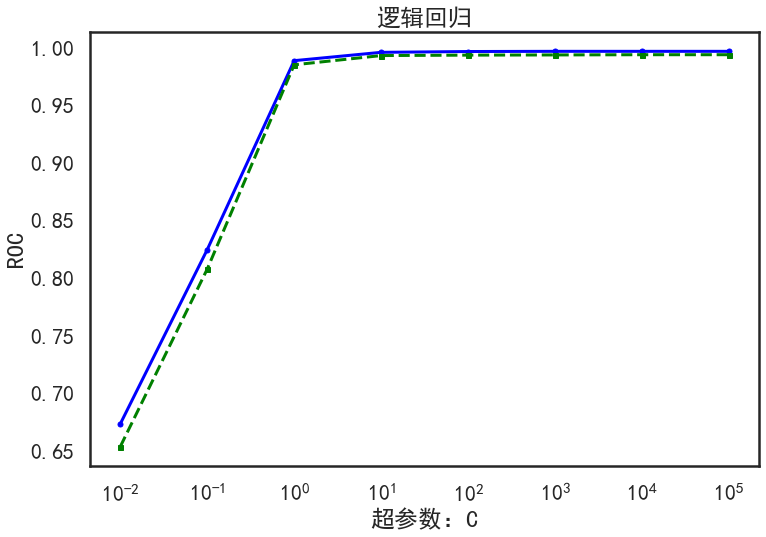

In [74]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.09
AUC（交叉验证数据）：0.9988


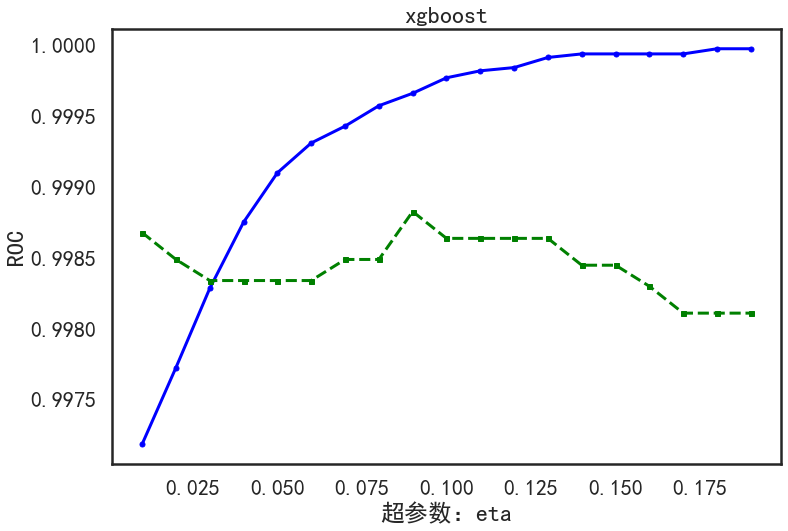

In [81]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.07
param['subsample'] = 1.0
param['colsample_bytree'] = 0.1
param['max_depth'] = 3
param['num_parallel_tree'] = 7
param['min_child_weight'] = 1

parameter_dic = {'eta':np.arange(0.01, 0.2, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用XGBoost及其最优超参数对测试数据进行预测，输出提交文件。

In [82]:
# XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.09
param['subsample'] = 1.0
param['colsample_bytree'] = 0.1
param['max_depth'] = 3
param['num_parallel_tree'] = 7
param['min_child_weight'] = 1

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [75]:
best_clf = LogisticRegression(C=10000,multi_class='auto', solver='liblinear')
ytrain_pred_proba, ytest_pred_proba = prediction(best_clf, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

3.5.3 REGED2

In [86]:
dataset_number = 2
feature_sel = [str(i) for i in [251, 321, 930, 825]]

Xtrain = Xtrain_df[feature_sel].values
ytrain = ytrain_df.values.ravel()
test_dataset = '{}{}'.format(dataset, dataset_number)
Xtest_df = pd.read_table(os.path.join(dataset.upper(), '{}{}_text'.format(dataset, dataset_number), '{}_test.data'.format(test_dataset)), names=feature_cols, sep=' ', index_col=False)
Xtest = Xtest_df[feature_sel].values

最优的C为：10
AUC（交叉验证数据）：0.9822


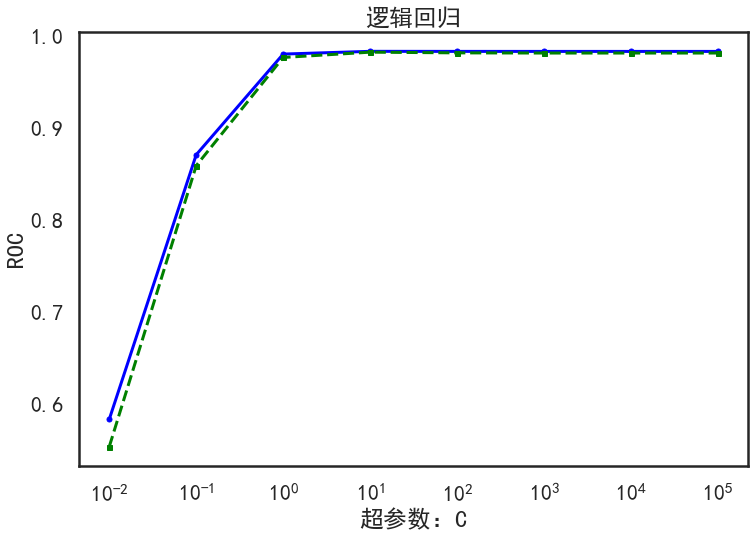

In [77]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}
train_mean, cv_mean = cv_result(clf, parameter_dic, Xtrain, ytrain)
plot_cv_curve(clf, train_mean, cv_mean, parameter_dic)

最优的eta为：0.15000000000000002
AUC（交叉验证数据）：0.9977


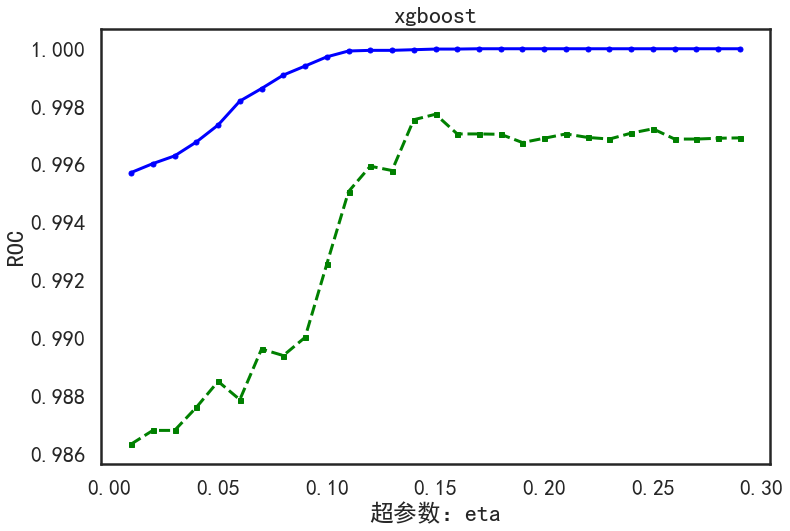

In [87]:
#XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.15
param['subsample'] = 1.0
param['colsample_bytree'] = 0.1
param['max_depth'] = 6
param['num_parallel_tree'] = 2
param['min_child_weight'] = 0

parameter_dic = {'eta':np.arange(0.01, 0.3, 0.01)}
train_mean, cv_mean, boost_round_mean = cv_result_xgboost(param, parameter_dic, Xtrain, ytrain)
plot_cv_curve(xgb, train_mean, cv_mean, parameter_dic)

使用XGBoost及其最优超参数对测试数据进行预测，输出提交文件。

In [88]:
# XGBoost
param = {} 
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['booster'] = 'gbtree'
param['silent'] = 1

param['eta'] = 0.15
param['subsample'] = 1.0
param['colsample_bytree'] = 0.1
param['max_depth'] = 6
param['num_parallel_tree'] = 2
param['min_child_weight'] = 0

num_boost_round = boost_round_mean[np.argmax(cv_mean)]
ytrain_pred_proba, ytest_pred_proba = prediction_xgboost(param, num_boost_round, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

In [78]:
best_clf = LogisticRegression(C=10,multi_class='auto', solver='liblinear')
ytrain_pred_proba, ytest_pred_proba = prediction(best_clf, Xtrain, ytrain, Xtest)
output(test_dataset, ytrain_pred_proba, ytest_pred_proba, feature_sel)

3.6 对三个数据集均完成预测后，输出提交文件。

In [89]:
with ZipFile('{}.zip'.format(dataset), 'w') as zipObj:
    for i in range(3):
        zipObj.write('{}{}_train.predict'.format(dataset, i))
        zipObj.write('{}{}_test.predict'.format(dataset, i))
        zipObj.write('{}{}_feat.ulist'.format(dataset, i))

#### 参考资料

[1] Pearl, J. (2009). Causality. Cambridge: Cambridge University Press. doi:10.1017/CBO9780511803161

[2] Spirtes et al., 1993 P. Spirtes, C.N. Glymour, and R. Scheines. Causation, Prediction, and Search. Springer-Verlag, New York, 1993.